In [1]:
# ------------------------------------------------------------------------------
# 
#    CNOTExRec trainer. Use 4 RNNs with 1 LSTM cell to train X & Z at same time.
#
#    Copyright (C) 2017 Pooya Ronagh
# 
# ------------------------------------------------------------------------------

from builtins import range
import numpy as np
import tensorflow as tf
import sys
from util import y2indicator
import threading
import sys
import os
import json
from time import localtime, strftime, clock
import bayesopt
from bayesoptmodule import BayesOptContinuous, BayesOptDiscrete

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# The CSS code generator matrix
G= np.matrix([[0,0,0,1,1,1,1], \
              [0,1,1,0,0,1,1], \
              [1,0,1,0,1,0,1]]).astype(np.int32)
error_keys= ['errX3', 'errX4', 'errZ3', 'errZ4']
syndrome_keys= ['synX12', 'synX34', 'synZ12', 'synZ34']

class Data:

    def __init__(self, data):
        self.input= {}
        self.output= {}
        self.output_ind= {}
        self.input['errX3']= np.concatenate( \
            (data['synX12'], data['synX34']), axis= 1).reshape(-1, 2, 6)
        self.input['errX4']= np.concatenate( \
            (data['synX12'], data['synX34']), axis= 1).reshape(-1, 2, 6)
        self.input['errZ3']= np.concatenate( \
            (data['synZ12'], data['synZ34']), axis= 1).reshape(-1, 2, 6)
        self.input['errZ4']= np.concatenate( \
            (data['synZ12'], data['synZ34']), axis= 1).reshape(-1, 2, 6)
        for key in error_keys:
            self.output[key]= data[key]
        for key in error_keys:
            self.output_ind[key]=\
            y2indicator(data[key],2**7).astype(np.float32)

def io_data_factory(data, test_size):

    train_data_arg = {key:data[key][:-test_size,] for key in data.keys()}
    test_data_arg  = {key:data[key][-test_size:,] for key in data.keys()}
    train_data = Data(train_data_arg)
    test_data = Data(test_data_arg)
    return train_data, test_data

def find_logical_fault(recovery, err):

    p_binary= '{0:07b}'.format(recovery)
    t_binary= '{0:07b}'.format(int(err))
    err_list= [int(a!=b) for a, b in zip(p_binary, t_binary)]
    err= np.matrix(err_list).astype(np.int32)
    syndrome= np.dot(G, err.transpose()) % 2
    correction_index= np.dot([[4, 2, 1]], syndrome) - 1
    correction = y2indicator(correction_index, 7)
    coset= (err + correction) % 2
    logical_err= np.sum(coset) % 2
    return logical_err

def num_logical_fault(prediction, test):

    error_counter= 0.0
    for i in range(len(prediction[error_keys[0]])):
        for key in error_keys:
            if (find_logical_fault(prediction[key][i], test.output[key][i])):
                error_counter+=1
                break
    return error_counter/len(prediction[error_keys[0]])

def get_data(filename):

    data= {}
    for key in syndrome_keys:
        data[key]= []
    for key in error_keys:
        data[key]= []
    with open(filename) as file:
        first_line = file.readline();
        p, lu_avg, lu_std, data_size = first_line.split(' ')
        p= float(p)
        lu_avg= float(lu_avg)
        lu_std= float(lu_std)
        data_size= int(data_size)
        for line in file.readlines():
            line_list= line.split(' ')
            data['synX12'].append([bit for bit in ''.join(line_list[0:2])])
            data['synX34'].append([bit for bit in ''.join(line_list[2:4])])
            data['synZ12'].append([bit for bit in ''.join(line_list[8:10])])
            data['synZ34'].append([bit for bit in ''.join(line_list[10:12])])
            data['errX3'].append([int(line_list[6],2)])
            data['errX4'].append([int(line_list[7],2)])
            data['errZ3'].append([int(line_list[14],2)])
            data['errZ4'].append([int(line_list[15],2)])
    for key in data.keys():
        data[key]= np.array(data[key]).astype(np.float32)
    return data, p, lu_avg, lu_std, data_size

def train(param, train_data, test_data, \
          num_classes, num_inputs, input_size, n_batches):

    prediction= {}
    verbose= param['usr']['verbose']
    batch_size= param['opt']['batch size']
    learning_rate= param['opt']['learning rate']
    num_iterations= param['opt']['iterations']
    momentum_val= param['opt']['momentum']
    decay_rate= param['opt']['decay']
    num_hidden= param['nn']['num hidden'] 
    W_std= param['nn']['W std'] 
    b_std= param['nn']['b std'] 

    # define all parts of the tf graph
    tf.reset_default_graph()
    x = {}
    y = {}
    lstm = {}
    lstmOut = {}
    W= {}
    b= {}
    logits= {}
    loss= {}
    predict= {}
    
    for key in error_keys:
        with tf.variable_scope(key):

            x[key] = tf.placeholder(tf.float32, [None, num_inputs, input_size])
            y[key] = tf.placeholder(tf.float32, [None, num_classes])
            lstm[key] = tf.contrib.rnn.LSTMCell(num_hidden)
            lstmOut[key], _ = tf.nn.dynamic_rnn(lstm[key], x[key], dtype=tf.float32)
            W[key]= tf.Variable(tf.random_normal([num_hidden,num_classes], stddev=W_std))
            b[key]= tf.Variable(tf.random_normal([num_classes], stddev=b_std))
            logits[key]= tf.matmul(lstmOut[key][:,-1,:], W[key]) + b[key]
            loss[key]= tf.nn.softmax_cross_entropy_with_logits(logits=logits[key], labels=y[key])
            predict[key]= tf.argmax(logits[key], 1)
    
    cost= tf.reduce_sum(sum(loss[key] for key in error_keys))
#     train = tf.train.AdagradOptimizer(learning_rate= learning_rate).minimize(cost)
    train = tf.train.RMSPropOptimizer(learning_rate, decay=decay_rate, momentum=momentum_val).minimize(cost)
    init = tf.global_variables_initializer()
    costs= []

    with tf.Session() as session:
        if (verbose): print('session begins '),
        session.run(init)

        for i in range(num_iterations):
            if (verbose): print('.'),

            for j in range(n_batches):
                beg= j * batch_size
                end= j * batch_size + batch_size
                feed_dict={}
                for key in error_keys:
                    feed_dict[x[key]]= train_data.input[key][beg:end,]
                    feed_dict[y[key]]= train_data.output_ind[key][beg:end,]
                session.run(train, feed_dict)

            feed_dict={}
            for key in error_keys:
                feed_dict[x[key]]= test_data.input[key]
                feed_dict[y[key]]= test_data.output_ind[key]
            test_cost = session.run(cost, feed_dict)
            costs.append(test_cost)

        for key in error_keys:
            prediction[key] = session.run(predict[key], \
                feed_dict= {x[key]: test_data.input[key]})
        if (verbose): print(' session ends.')

    plt.plot(costs)
    plt.show()
    return num_logical_fault(prediction, test_data)

class BayesOptTest(BayesOptContinuous):

    def __init__(self, N, filename, param,\
            raw_data, p, lu_avg, lu_std, data_size):
        super(BayesOptTest, self).__init__(N)
        self.filename= filename
        self.param= param
        self.raw_data= raw_data
        self.p= p
        self.lu_avg= lu_avg
        self.lu_std= lu_std
        self.data_size= data_size

        self.test_fraction= self.param['data']['test fraction']
        self.total_size= np.shape(self.raw_data['synX12'])[0]
        self.test_size= int(self.test_fraction * self.total_size)
        self.train_data, self.test_data = \
            io_data_factory(self.raw_data, self.test_size)

        self.batch_size= self.param['opt']['batch size']
        self.train_size= self.total_size - self.test_size
        self.n_batches = self.train_size // self.batch_size
        self.error_scale= 1.0*self.total_size/self.data_size

        self.num_classes= 2**7
        self.num_inputs= 2
        self.input_size= 6

    def evaluateSample(self, x):
        
        print('new sample='+ str(x))
#         self.param['opt']['batch size']= int(x[0] * 100) 
        self.param['opt']['learning rate']= 10**x[0] 
#         self.param['opt']['iterations']= int(x[2] * 10)
#         self.param['opt']['momentum']= x[1] 
#         self.param['opt']['decay']= x[1]
#         self.param['nn']['num hidden']= int(x[5] * 10)
        self.param['nn']['W std']= 10**x[1]
#         self.param['nn']['b std']= 10**x[3]

        avg = train(self.param, self.train_data, self.test_data, \
            self.num_classes, self.num_inputs, self.input_size, self.n_batches)
        print('result= '+ str(self.error_scale * avg))
        return self.error_scale * avg

 Reading data from SyndromeAndError4.000e-04.txt
session begins  . . . . . . . . . .  session ends.


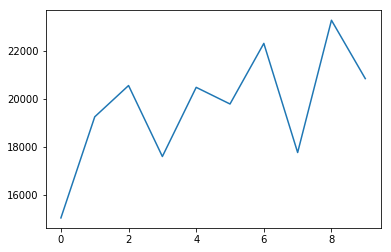

[
  {
    "opt": {
      "batch size": 1000, 
      "number of batches": 610
    }, 
    "res": {
      "p": 0.0004, 
      "nn avg": 0.0005210007684932517, 
      "lu avg": 0.0007708, 
      "lu std": 2.45920416328675e-05, 
      "nn std": 0
    }, 
    "data": {
      "path": "SyndromeAndError4.000e-04.txt", 
      "test set size": 67795, 
      "total data size": 677951, 
      "fault scale": 0.0677951
    }
  }
]


In [7]:
### Run an entire benchmark

param= {}
param['nn']= {}
param['opt']= {}
param['data']= {}
param['usr']= {}
param['nn']['num hidden']= 500
param['nn']['W std']= 0.01
param['nn']['b std']= 0.0
param['opt']['batch size']= 1000
param['opt']['learning rate']= 0.005
param['opt']['iterations']= 10
param['opt']['momentum']= 0.98
param['opt']['decay']= 0.98
param['data']['test fraction']= 0.1
param['usr']['verbose']= True

verbose= param['usr']['verbose']
output= []
num_classes= 2**7
num_inputs= 2
input_size= 6

datafolder= '../e-04/'
file_list= os.listdir(datafolder)
file_list= ['SyndromeAndError4.000e-04.txt']

for filename in file_list:
    # Read data and find how much null syndromes to assume for error_scale
    print("Reading data from " + filename)
    raw_data, p, lu_avg, lu_std, data_size = get_data(datafolder + filename)

    test_fraction= param['data']['test fraction']
    total_size= np.shape(raw_data['synX12'])[0]
    test_size= int(test_fraction * total_size)
    train_data, test_data = io_data_factory(raw_data, test_size)

    batch_size= param['opt']['batch size']
    train_size= total_size - test_size
    n_batches = train_size // batch_size
    error_scale= 1.0*total_size/data_size

    avg= train(param, train_data, test_data, \
        num_classes, num_inputs, input_size, n_batches)

    run_log= {}
    run_log['data']= {}
    run_log['opt']= {}
    run_log['res']= {}
    run_log['data']['path']= filename
    run_log['data']['fault scale']= error_scale
    run_log['data']['total data size']= total_size
    run_log['data']['test set size']= test_size
    run_log['opt']['batch size']= batch_size
    run_log['opt']['number of batches']= n_batches
    run_log['res']['p']= p
    run_log['res']['lu avg']= lu_avg
    run_log['res']['lu std']= lu_std
    run_log['res']['nn avg'] = error_scale * avg
    run_log['res']['nn std'] = 0
    output.append(run_log)

print(json.dumps(output, indent=2))

 new sample=[-5.34749082 -3.50679544]
session begins  . . . . . . . . . .  session ends.


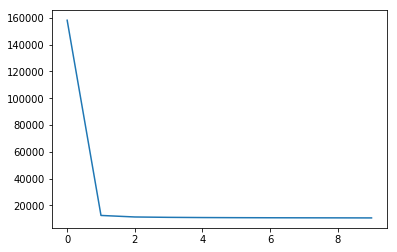

result= 0.00042300062394
new sample=[-2.74305822 -0.38986951]
session begins  . . . . . . . . . .  session ends.


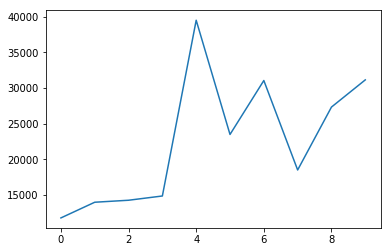

result= 0.000964001421934
new sample=[-6.  2.]
session begins  . . . . . . . . . .  session ends.


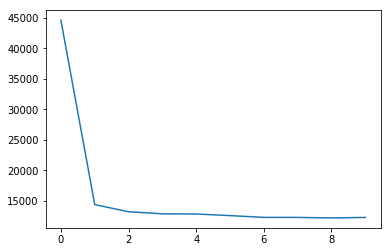

result= 0.00043500064164
new sample=[-2. -4.]
session begins  . . . . . . . . . .  session ends.


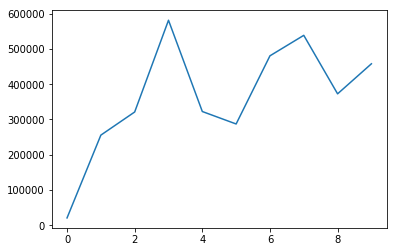

result= 0.000859001267055
new sample=[-2.  2.]
session begins  . . . . . . . . . .  session ends.


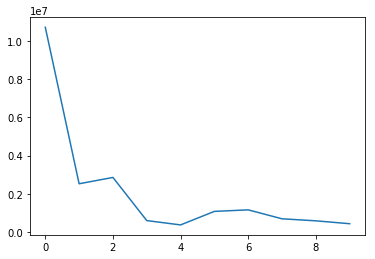

result= 0.00267300394277
new sample=[-4.08040079  1.99988616]
session begins  . . . . . . . . . .  session ends.


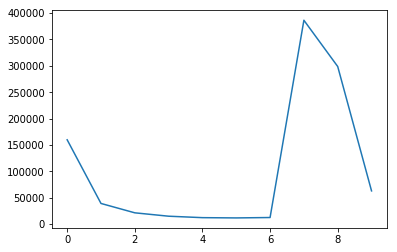

result= 0.000490000722767
new sample=[-5.99962771 -0.92406812]
session begins  . . . . . . . . . .  session ends.


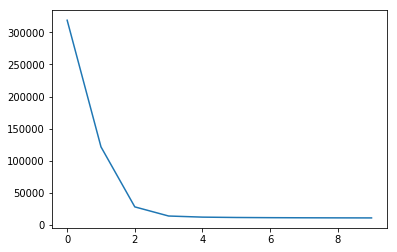

result= 0.000484000713917
new sample=[-6. -4.]
session begins  . . . . . . . . . .  session ends.


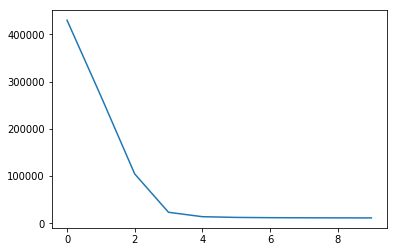

result= 0.000520000767018
new sample=[-3.4914683 -4.       ]
session begins  . . . . . . . . . .  session ends.


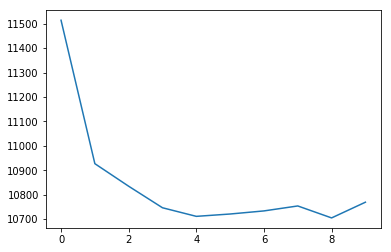

result= 0.000391000576739
new sample=[-4.67942309 -0.04481451]
session begins  . . . . . . . . . .  session ends.


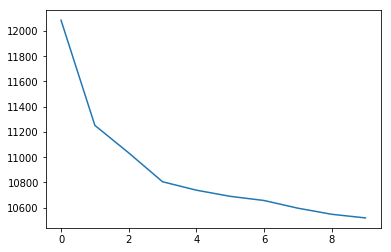

result= 0.000376000554613
new sample=[-2.00007102 -2.08939613]
session begins  . . . . . . . . . .  session ends.


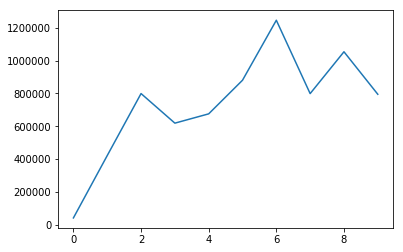

result= 0.00421500621727
new sample=[-3.88852813 -1.88185683]
session begins  . . . . . . . . . .  session ends.


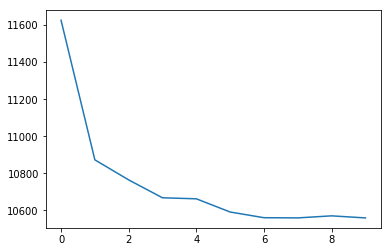

result= 0.000368000542813
new sample=[-3.25943237  1.15038358]
session begins  . . . . . . . . . .  session ends.


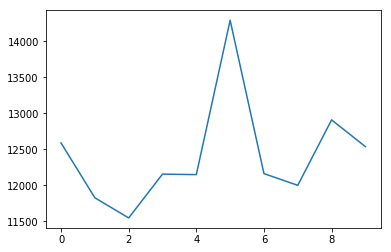

result= 0.00044100065049
new sample=[-5.99962083 -2.60472782]
session begins  . . . . . . . . . .  session ends.


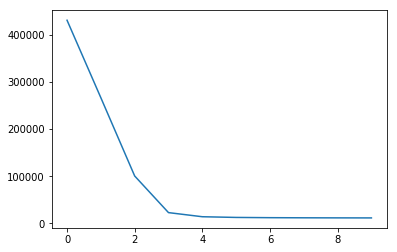

result= 0.000517000762593
new sample=[-5.41253817  1.2331224 ]
session begins  . . . . . . . . . .  session ends.


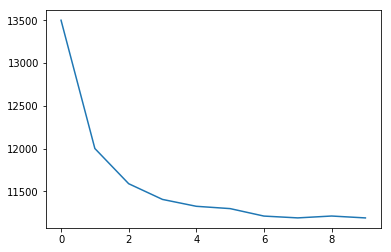

result= 0.000414000610665
new sample=[-5.06892016 -1.66595539]
session begins  . . . . . . . . . .  session ends.


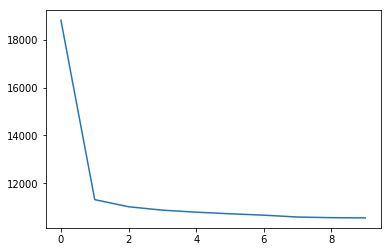

result= 0.000383000564938
new sample=[-3.67379224 -0.28754547]
session begins  . . . . . . . . . .  session ends.


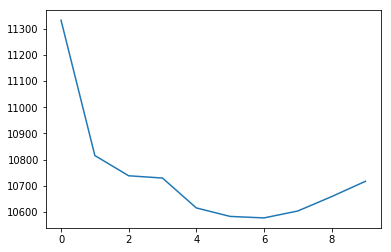

result= 0.000375000553138
new sample=[-4.45313279 -3.99942931]
session begins  . . . . . . . . . .  session ends.


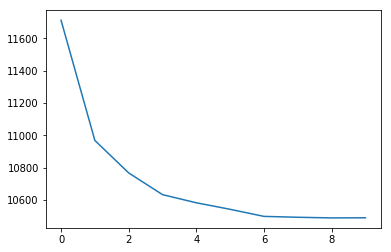

result= 0.000368000542813
new sample=[-5.99962545  0.72955049]
session begins  . . . . . . . . . .  session ends.


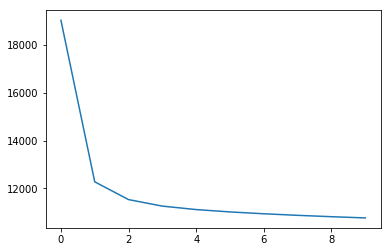

result= 0.00042100062099
new sample=[-2.66059055 -4.        ]
session begins  . . . . . . . . . .  session ends.


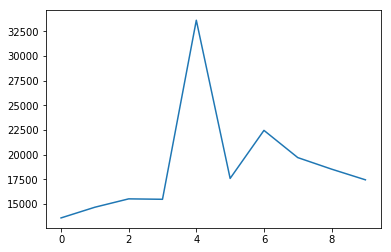

result= 0.000517000762593
new sample=[-4.41802571 -2.90157327]
session begins  . . . . . . . . . .  session ends.


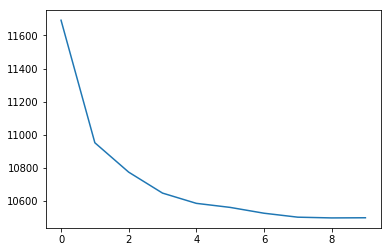

result= 0.000364000536913
new sample=[-4.28318394  1.08206224]
session begins  . . . . . . . . . .  session ends.


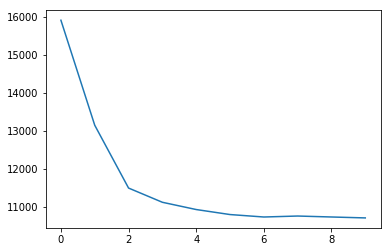

result= 0.000369000544288
new sample=[-2.00007362  0.55528874]
session begins  . . . . . . . . . .  session ends.


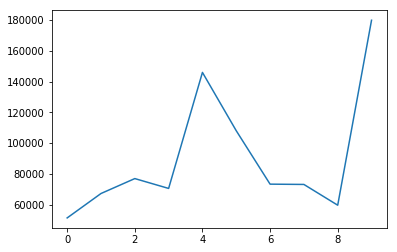

result= 0.000783001154952
new sample=[-4.96067461  1.99987631]
session begins  . . . . . . . . . .  session ends.


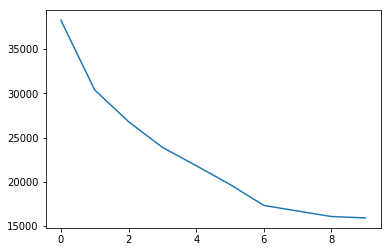

result= 0.000488000719817
new sample=[-4.34746131 -1.30385504]
session begins  . . . . . . . . . .  session ends.


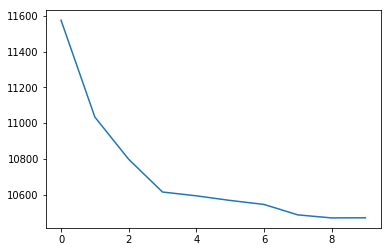

result= 0.000366000539863
new sample=[-5.48094139 -0.18707056]
session begins  . . . . . . . . . .  session ends.


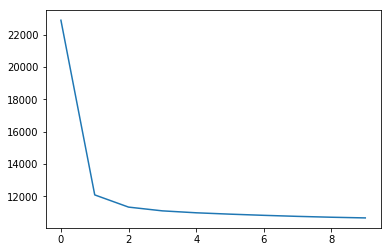

result= 0.000418000616565
new sample=[-2.57880743  0.82160579]
session begins  . . . . . . . . . .  session ends.


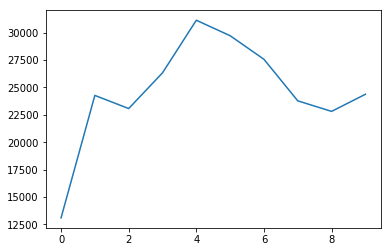

result= 0.000503000741943
new sample=[-3.66317788  0.56575553]
session begins  . . . . . . . . . .  session ends.


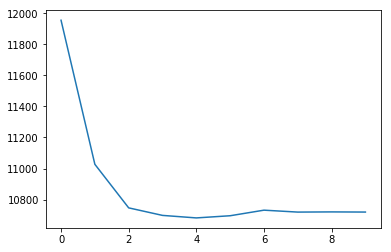

result= 0.000387000570839
new sample=[-5.05011092 -2.58156785]
session begins  . . . . . . . . . .  session ends.


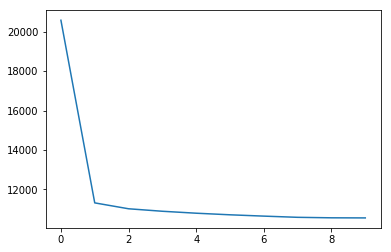

result= 0.000386000569364
new sample=[-5.64866467 -1.8149503 ]
session begins  . . . . . . . . . .  session ends.


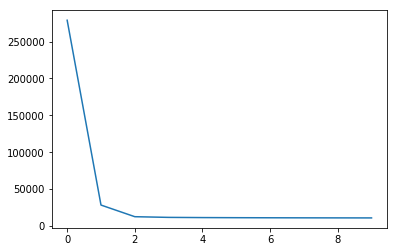

result= 0.000467000688841
new sample=[-4.39460597 -2.13513428]
session begins  . . . . . . . . . .  session ends.


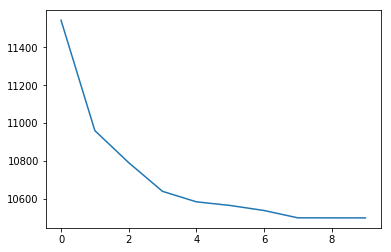

result= 0.000366000539863
new sample=[-3.67801617 -3.07396484]
session begins  . . . . . . . . . .  session ends.


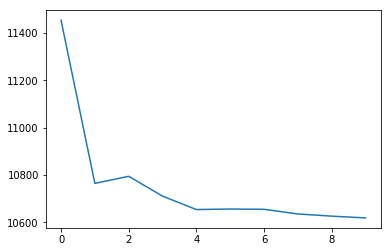

result= 0.000374000551663
new sample=[-5.11401288 -4.        ]
session begins  . . . . . . . . . .  session ends.


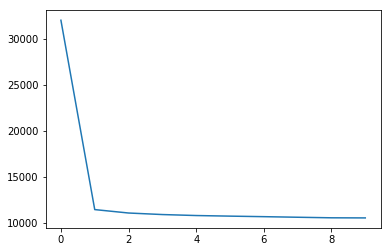

result= 0.000385000567888
new sample=[-4.91474548  0.82384763]
session begins  . . . . . . . . . .  session ends.


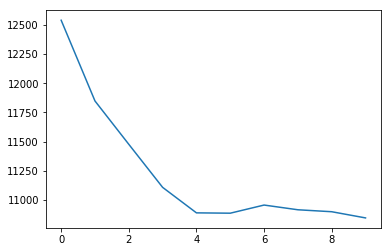

result= 0.000384000566413
new sample=[-4.00846754 -3.49569002]
session begins  . . . . . . . . . .  session ends.


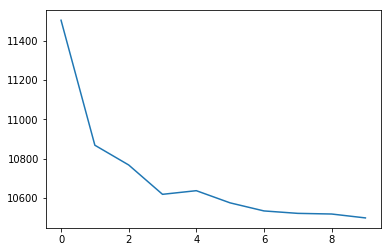

result= 0.000364000536913
new sample=[-4.14122835 -0.26079478]
session begins  . . . . . . . . . .  session ends.


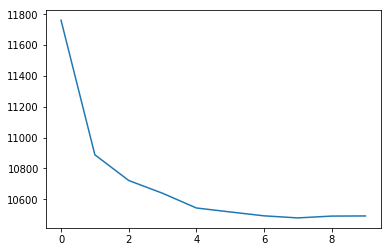

result= 0.000364000536913
new sample=[-3.10530802  0.43748412]
session begins  . . . . . . . . . .  session ends.


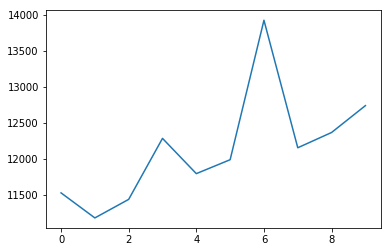

result= 0.000450000663766
new sample=[-3.97676506 -2.66190791]
session begins  . . . . . . . . . .  session ends.


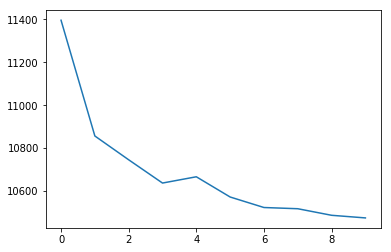

result= 0.000367000541338
new sample=[-4.78932898 -3.53274156]
session begins  . . . . . . . . . .  session ends.


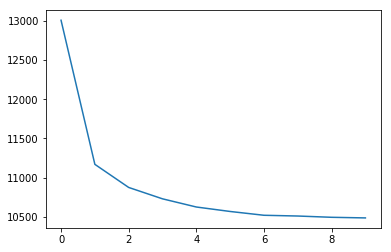

result= 0.000372000548713
new sample=[-5.032909   -0.79045785]
session begins  . . . . . . . . . .  session ends.


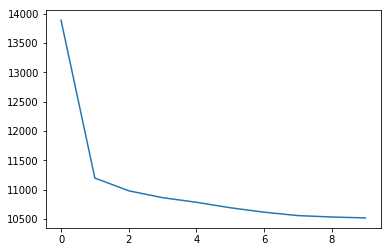

result= 0.000388000572314
new sample=[-3.84178815 -1.02861985]
session begins  . . . . . . . . . .  session ends.


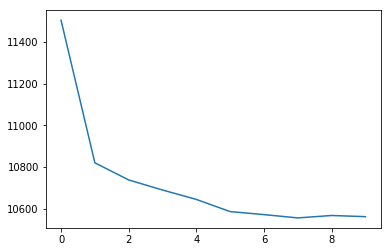

result= 0.000362000533963
new sample=[-4.54178733  1.60051821]
session begins  . . . . . . . . . .  session ends.


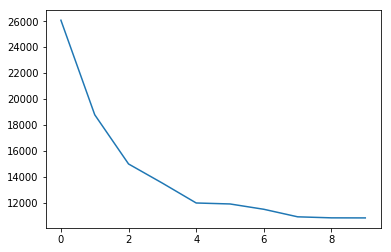

result= 0.000388000572314
new sample=[-5.99960814  1.45187058]
session begins  . . . . . . . . . .  session ends.


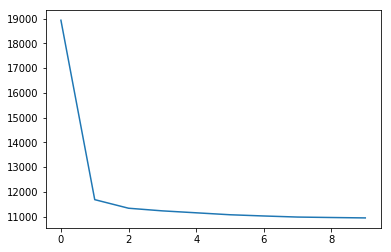

result= 0.000400000590014
new sample=[-3.84297097  1.37371786]
session begins  . . . . . . . . . .  session ends.


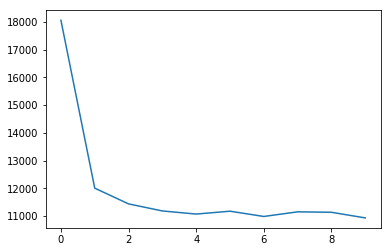

result= 0.000395000582639
new sample=[-5.62695749  1.99987529]
session begins  . . . . . . . . . .  session ends.


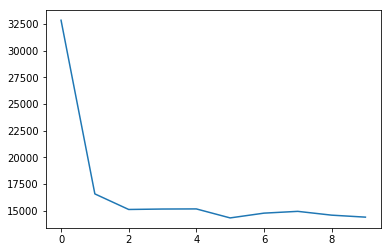

result= 0.000472000696217
new sample=[-5.25155884  0.39513016]
session begins  . . . . . . . . . .  session ends.


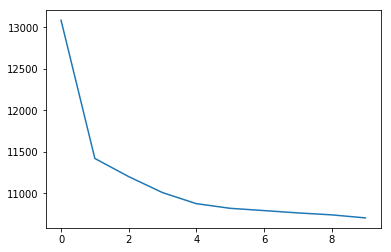

result= 0.000377000556088
new sample=[-3.43565513 -1.96875476]
session begins  . . . . . . . . . .  session ends.


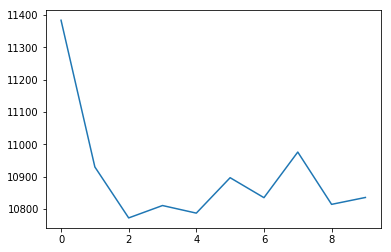

result= 0.000378000557563
new sample=[-3.51423325 -1.32639543]
session begins  . . . . . . . . . .  session ends.


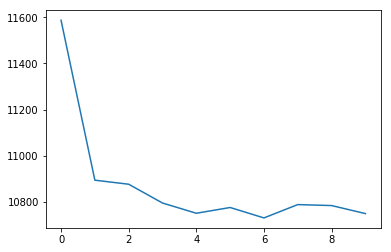

result= 0.000380000560513
new sample=[-4.55445477 -0.74573659]
session begins  . . . . . . . . . .  session ends.


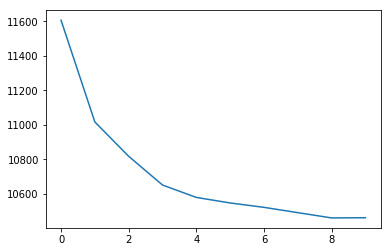

result= 0.000374000551663
new sample=[-3.95381969 -4.        ]
session begins  . . . . . . . . . .  session ends.


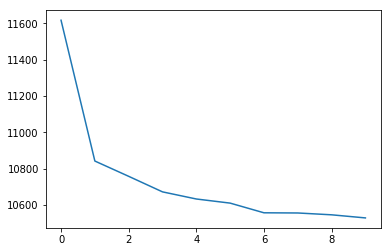

result= 0.000368000542813
new sample=[-3.63914715 -2.35196193]
session begins  . . . . . . . . . .  session ends.


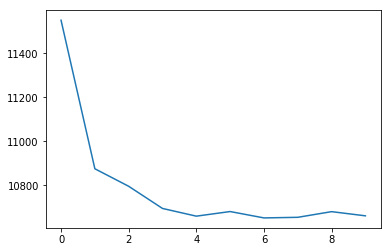

result= 0.000385000567888
new sample=[-4.69510043 -1.67182659]
session begins  . . . . . . . . . .  session ends.


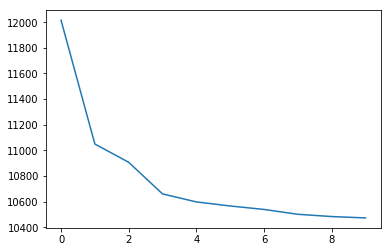

result= 0.000376000554613
('Result', 0.0003620005339626816, 'at', array([-3.84178815, -1.02861985]))
('Running time:', 9465.033598999999, 'seconds')


In [10]:
### Run hypertuning on the single file.

N = 2

# -  # 1. batch size= int(x[0] * 100) 
# 1. # 2. learning rate= 10**x[1] 
# -  # 3. iterations= int(x[2] * 10)
# - # 4. momentum= x[3] 
# - # 5. decay= x[4]
# -  # 6. num hidden= int(x[5] * 10)
# 2. # 7. W std= 10**x[6]
# - # 8. b std= 10**x[7]

# lb = np.array([1., -6., 1., .8, .8, 5., -2., -2.])
# ub = np.array([10., -2., 10., .99, .99, 100., 1., 1.])

# lb = np.array([10., -3., 0.5, .9, .6, 50., -4., -4.])
# ub = np.array([20., 1., 5., 0.999, .85, 150., 0., 0.])

lb = np.array([-6, -4.])
ub = np.array([-2, 2.])

param= {}
param['nn']= {}
param['opt']= {}
param['data']= {}
param['usr']= {}
param['nn']['num hidden']= 500
param['nn']['W std']= 0.1
param['nn']['b std']= 0.0
param['opt']['batch size']= 1000
param['opt']['learning rate']= 0.00001
param['opt']['iterations']= 10
param['opt']['momentum']= 0.99
param['opt']['decay']= 0.98
param['data']['test fraction']= 0.1
param['usr']['verbose']= True

datafolder= '../e-04/'
filename= 'SyndromeAndError4.000e-04.txt'
raw_data, p, lu_avg, lu_std, data_size = get_data(datafolder + filename)

engine = BayesOptTest(N, datafolder + filename, param,\
    raw_data, p, lu_avg, lu_std, data_size)

hyperparam = {}
hyperparam['n_iterations'] = 50
hyperparam['n_iter_relearn'] = 5
hyperparam['n_init_samples'] = 2
hyperparam['noise']= 1e-10
# hyperparam['l_type']= 'L_MCMC'
hyperparam['kernel_name'] = "kMaternARD5"
hyperparam['kernel_hp_mean'] = [1]
hyperparam['kernel_hp_std'] = [5]
hyperparam['surr_name'] = "sStudentTProcessNIG"
#hyperparam['crit_name'] = "cMI"

engine.parameters = hyperparam
engine.lower_bound = lb
engine.upper_bound = ub
start = clock()
mvalue, x_out, error = engine.optimize()
print("Result", mvalue, "at", x_out)
print("Running time:", clock() - start, "seconds")